In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, optimize
import h5py
import glob
import pmefm
from collections import OrderedDict
from kpfm.util import h5filename
from kpfm.util import kpfm_data
from kpfm import lockin
from kpfm import util
import sigutils
reload(pmefm)
reload(util)
reload(lockin)

ks = 14950.0

plt.rc('font', size=9)

@h5filename
def _h5toPMEFM(f):
    phi_t = f['CPD'][:]
    fs = f.attrs['Inputs.Scan rate [Hz]']
    dt = 1/fs
    T = phi_t.size * dt
    fx = f.attrs['Inputs.Pos Mod Freq (Hz)']
    x_m = f.attrs['Inputs.Pos Mod rms (V)'] * np.sqrt(2) * 0.2 * 15 * 0.167 
    x_tot = (f.attrs['Inputs.End scan [V]'] -
             f.attrs['Inputs.Start scan [V]']) * 0.125
    v_tip = x_tot / T

    return {'fs': fs, 'fx': fx, 'v_tip': v_tip, 'x_m': x_m, 'phi_t': phi_t}

def phase_err(dphase, dphi_max=np.pi/2):
    return abs(abs(dphase) - dphi_max) - dphi_max

In [2]:
fh = h5py.File('../data/KPFM-linescans/170217-1622DPh-BTBT-20V-no-mod-in-x.h5')

In [3]:
d = _h5toPMEFM('../data/KPFM-linescans/170217-1628DPh-BTBT-20V-50-nm-mod-x.h5')
ks = d['fs'] / d['v_tip']
fir2 = lockin.lock2(4.5/d['v_tip'], 1.1 , 1.1*4, ks)

Response:
f   mag       dB
   0.000 1.000    0.000
   0.550 0.983   -0.151
   1.100 0.927   -0.656
   4.400 0.095  -20.488
   6.063 0.002  -53.440
   8.800 0.000 -101.830
  12.126 0.000 -114.106
11037.642 0.000 -345.562


In [4]:
li = lockin.LockIn.from_x(d['phi_t'], d['fs'])
li.run(f0=4.5, fir=fir2)

In [5]:
def LiDec(li, Ndec):
    return lambda x: li(x)[::Ndec]

lid = LiDec(li, 1000)

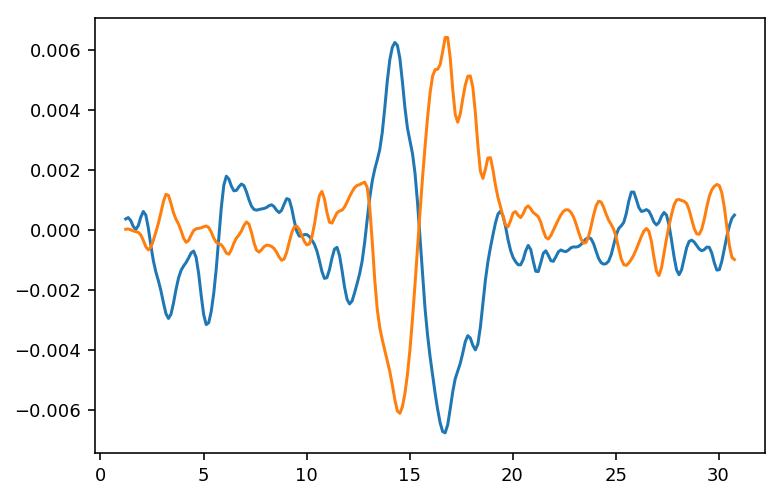

In [6]:
plt.plot(lid('t'), lid('z').real)
plt.plot(lid('t'), lid('z').imag)

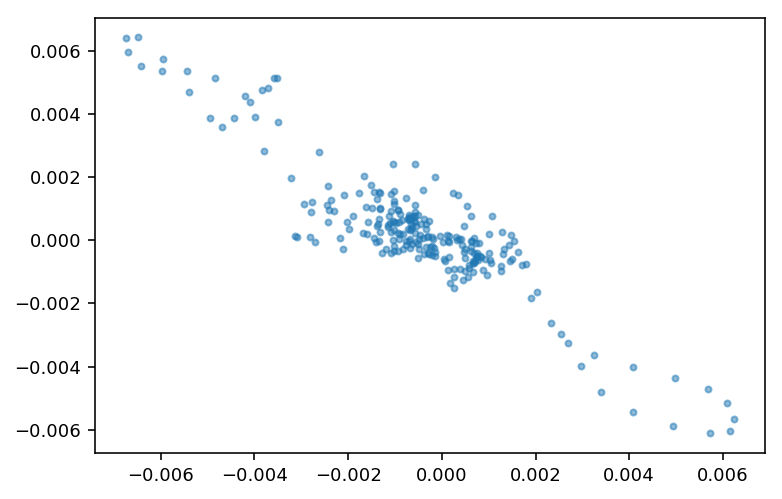

In [7]:
plt.plot(lid('z').real, lid('z').imag, '.', alpha=0.5)

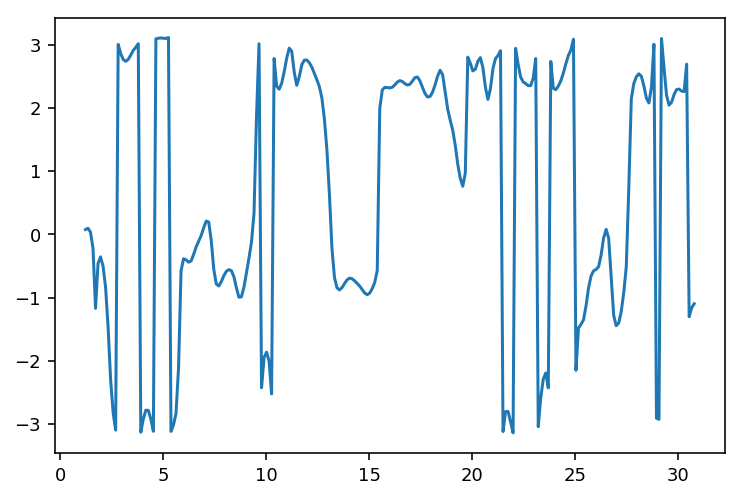

In [8]:
plt.plot(lid('t'), lid('phi'))

In [9]:
li.autophase()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.02251538948e-10
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1


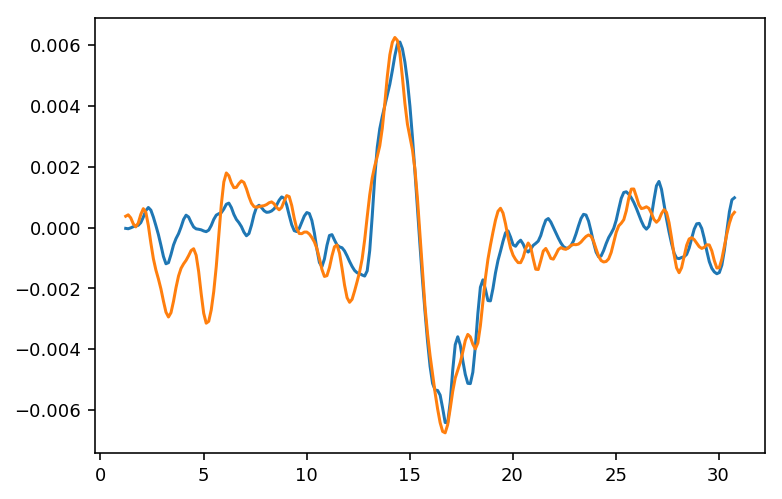

In [10]:
plt.plot(lid('t'), lid('X'))
plt.plot(lid('t'), lid('Y'))

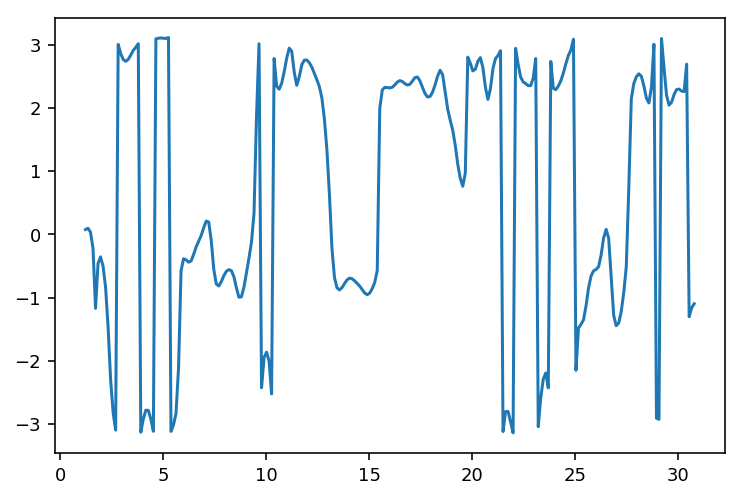

In [11]:
plt.plot(lid('t'), lid('phi'))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0855476269131
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6


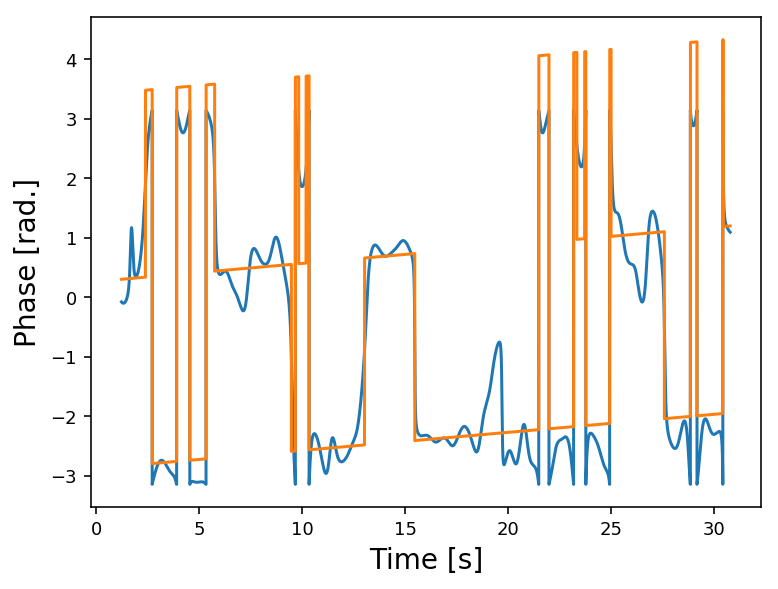

In [12]:
p50 = pmefm.PMEFMEx(**_h5toPMEFM('../data/KPFM-linescans/170217-1628DPh-BTBT-20V-50-nm-mod-x.h5'))
p50.fir_filter(fir_ac=fir2, fir_dc=fir2)
p50.auto_phase()
p50.plot_phase()
p50.output()

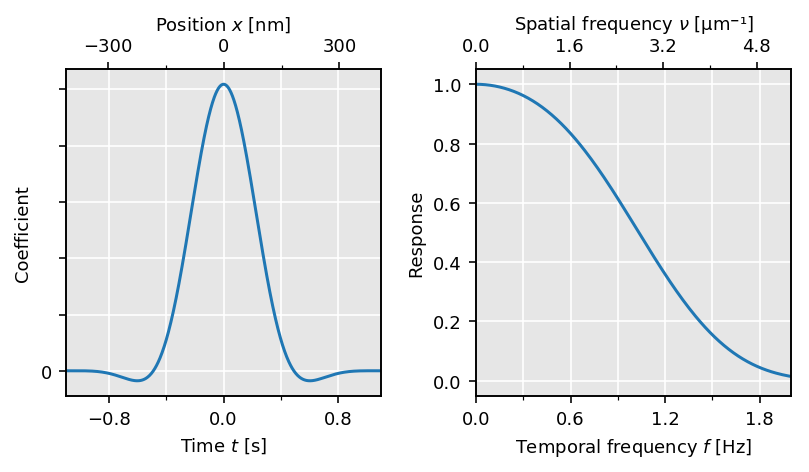

In [13]:
fig, axes = plt.subplots(figsize=(6.5, 3), ncols=2, subplot_kw=dict(facecolor='0.9'))



fig.subplots_adjust(wspace=0.30)

taxes = [ax.twiny() for ax in axes]

tt = np.arange(fir2.size)/8192
tt = tt - tt.mean()
xx = tt * p50.v_tip
f, resp = sigutils.freqz(fir2, xlim=(0.0, 5), N=500, xlog=False, fs=8192)
Ndec = 20

tmin, tmax = -1.1, 1.1
axes[0].plot(tt[::Ndec], fir2[::Ndec])
axes[0].set_xlabel("Time $t$ [s]")
axes[0].set_xticks([-0.8, 0, 0.8], minor=False)
axes[0].set_xticks([-0.4, 0.4], minor=True)
axes[0].set_xlim(tmin, tmax)

for ax in axes:
    ax.grid(color='1', zorder=0, which='both')

taxes[0].plot(xx[::Ndec]*1000, fir2[::Ndec])
taxes[0].cla()
taxes[0].set_xticks([-300, 0, 300])
taxes[0].set_xticks([-150, 150], minor=True)
taxes[0].set_xlim(tmin*p50.v_tip*1000, tmax*p50.v_tip*1000)
taxes[0].set_xlabel(u"Position $x$ [nm]")


axes[0].set_yticklabels(['0' if tick == 0 else '' for tick in axes[0].get_yticks()])
axes[0].set_ylabel("Coefficient")

axes[1].plot(f, abs(resp))
fticks = np.arange(0, 1.9, 0.6)
fticks_minor = np.arange(0.3, 1.7, 0.6)
axes[1].set_xticks(fticks)
axes[1].set_xticks(fticks_minor, minor=True)
axes[1].set_ylabel("Response")
axes[1].set_xlabel("Temporal frequency $f$ [Hz]")

# axes[1].set_ylim(-80, 10)
xmin, xmax = 0.0, 2.0
axes[1].set_xlim(xmin, xmax)

taxes[1].plot(f/p50.v_tip, abs(resp))
taxes[1].cla()
taxes[1].set_xlabel(u"Spatial frequency $\\nu$ [µm⁻¹]")
taxes[1].set_xlim(xmin/p50.v_tip, xmax/p50.v_tip)
taxes[1].set_xticks(fticks*8/3)
taxes[1].set_xticks(fticks_minor*8/3, minor=True)

In [14]:
# fig.savefig('filter-hpm.pdf', bbox_inches='tight')

In [15]:
['0' if tick == 0 else '' for tick in axes[0].get_yticks()]

['', '0', '', '', '', '', '', '']

In [16]:
def PM(p, m, Ndec=1):
    return lambda x: getattr(p, x)[m][::Ndec]
p50m = PM(p50, p50.m, 500)

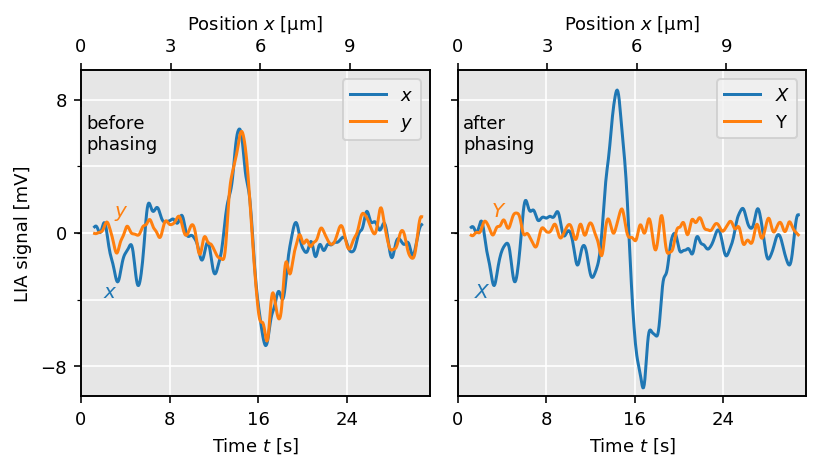

In [30]:
fig, axes = plt.subplots(figsize=(6.5, 3), ncols=2, subplot_kw=dict(facecolor='0.9'), sharey=True)



fig.subplots_adjust(wspace=0.08)

Ndec = 500
scale = 1000

taxes = [ax.twiny() for ax in axes]

l1, = axes[0].plot(p50m('t'), p50m('phi_lock').real*scale, label="$x$")
l2, = axes[0].plot(p50m('t'), p50m('phi_lock').imag*scale, label="$y$")

taxes[0].plot(p50m('x_dc'), p50m('V_ac').real*scale)
taxes[0].cla()

axes[1].plot(p50m('t'), p50m('V_ac').real*scale, label="$X$")
axes[1].plot(p50m('t'), p50m('V_err').real*scale, label="Y")

taxes[1].plot(p50m('x_dc'), p50m('V_ac').real*scale)
taxes[1].cla()

xmin, xmax = 0, 31.5

for tax in taxes:
    tax.set_xlabel(u"Position $x$ [µm]")
    tax.set_xticks(np.linspace(0, 9, 4))
    tax.set_xlim(xmin * p50.v_tip, xmax*p50.v_tip)

for ax in axes:
    ax.grid(color='1', zorder=0, which='both')
    ax.set_xlabel(u"Time $t$ [s]")
    ax.set_xticks(np.linspace(0, 9, 4) * 8/3)
    ax.set_yticks(np.arange(-4, 4.1, 4), minor=True)
    ax.set_yticks(np.linspace(-8, 8, 3))
    ax.set_ylim(-9.8, 9.8)
    ax.set_xlim(xmin, xmax)
    ax.legend(facecolor="0.95")
    
axes[0].set_ylabel("LIA signal [mV]")

axes[0].text(0.5, 5, "before\nphasing", bbox=dict(facecolor='0.9', edgecolor='none', alpha=0.2))
axes[1].text(0.5, 5, "after\nphasing", bbox=dict(facecolor='0.9', edgecolor='none', alpha=0.2))
axes[0].text(2, -3.9, "$x$", color=l1.get_color(), fontsize=10)
axes[0].text(3, 1.0, "$y$", color=l2.get_color(), fontsize=10)

axes[1].text(1.5, -3.9, "$X$", color=l1.get_color(), fontsize=10)
axes[1].text(3, 1.0, "$Y$", color=l2.get_color(), fontsize=10)



In [34]:
fig.savefig("../figs/SI-LIA-phase.pdf", bbox_inches='tight')

In [36]:
p50.mb / np.array([2*np.pi, 1])

array([ 0.00482784,  0.26723397])

In [37]:
def farey(x, N):
    a, b = 0, 1
    c, d = 1, 1
    while (b <= N and d <= N):
        mediant = float(a+c)/(b+d)
        if x == mediant:
            if b + d <= N:
                return a+c, b+d
            elif d > b:
                return c, d
            else:
                return a, b
        elif x > mediant:
            a, b = a+c, b+d
        else:
            c, d = a+c, b+d
 
    if (b > N):
        return c, d
    else:
        return a, b